In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:


df = pd.read_csv(r"C:\Users\kunal\Downloads\deforestation_dataset.csv")



In [3]:

print(df.info())
print(df.head())
print(df.isnull().sum())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          100 non-null    object 
 1   Year                             100 non-null    int64  
 2   Forest_Loss_Area_km2             100 non-null    int64  
 3   Tree_Cover_Loss_percent          100 non-null    float64
 4   CO2_Emission_mt                  100 non-null    int64  
 5   Rainfall_mm                      100 non-null    float64
 6   Population                       100 non-null    int64  
 7   GDP_Billion_USD                  100 non-null    float64
 8   Agriculture_Land_Percent         100 non-null    float64
 9   Deforestation_Policy_Strictness  100 non-null    int64  
 10  Corruption_Index                 100 non-null    float64
 11  International_Aid_Million_USD    100 non-null    int64  
 12  Illegal_Lumbering_Incid

In [4]:



df = df.fillna(df.median(numeric_only=True))
df = df.dropna()  




In [5]:
categorical_cols = ['Deforestation_Policy_Strictness', 'Corruption_Index']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

In [7]:
features = [col for col in df.columns if col not in ['Country', 'Year', 'Forest_Loss_Area_km2', 'Tree_Cover_Loss_percent']]

target = 'Tree_Cover_Loss_percent'

X = df[features]
y = df[target]

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [11]:
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)


In [12]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR^2: {r2}")


MAE: 2.043550648878789
MSE: 5.430873004412762
RMSE: 2.330423353043983
R^2: -0.13664404493525129


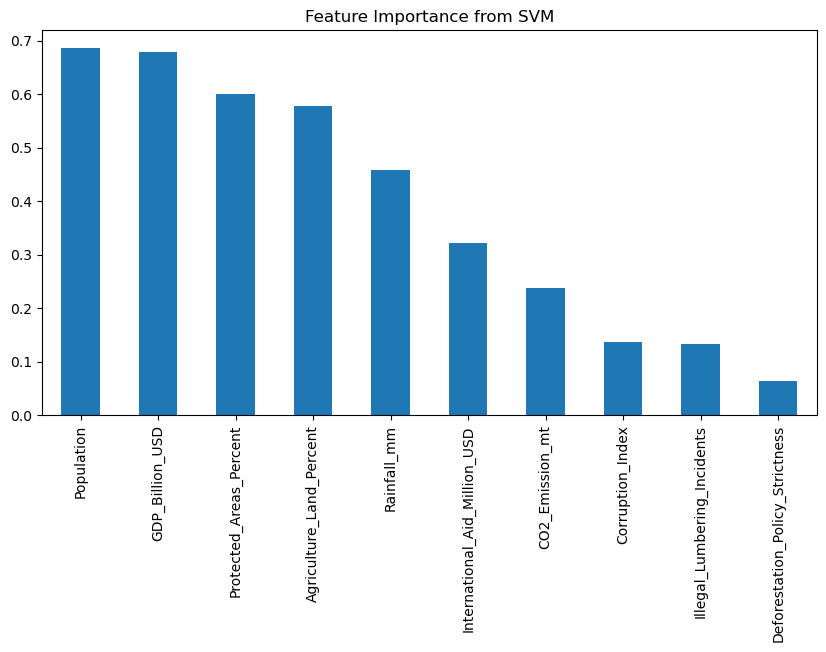

In [13]:
if hasattr(svm_model, 'coef_'):
    feature_importance = pd.Series(np.abs(svm_model.coef_[0]), index=features)
    plt.figure(figsize=(10,5))
    feature_importance.sort_values(ascending=False).plot(kind='bar')
    plt.title('Feature Importance from SVM')
    plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV

params = {'kernel': ['linear', 'rbf', 'poly'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
grid = GridSearchCV(SVR(), params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}


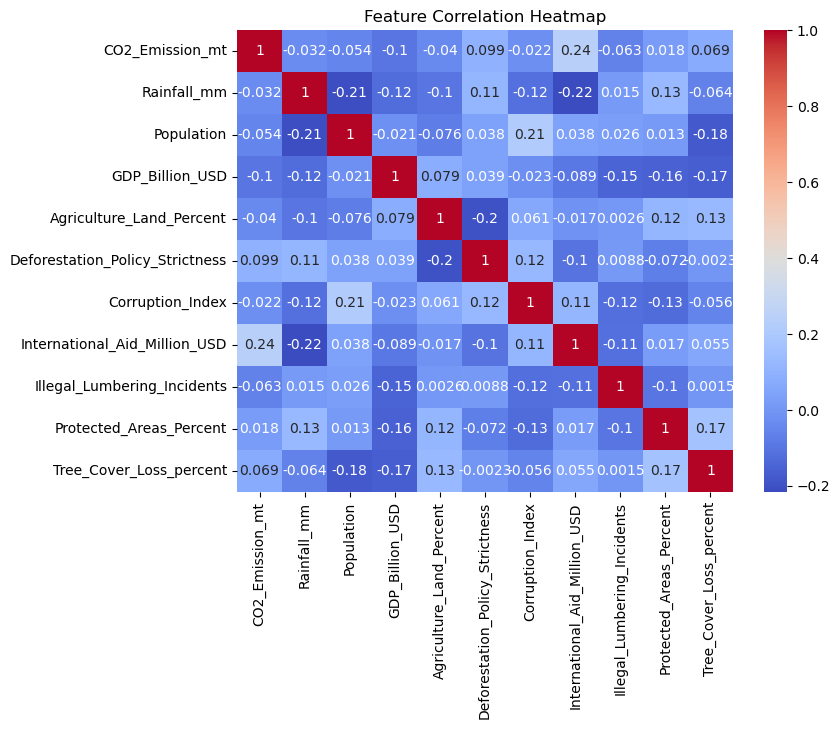

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

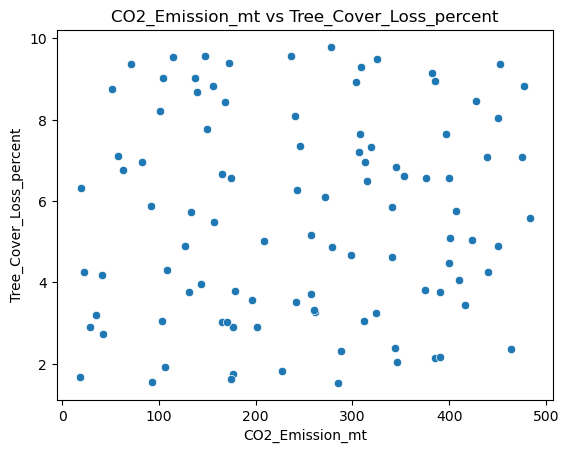

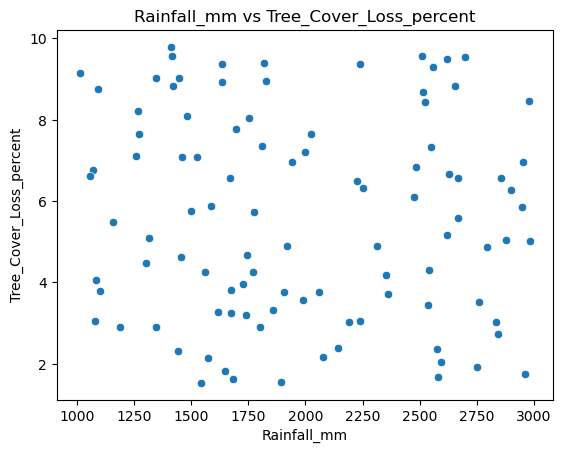

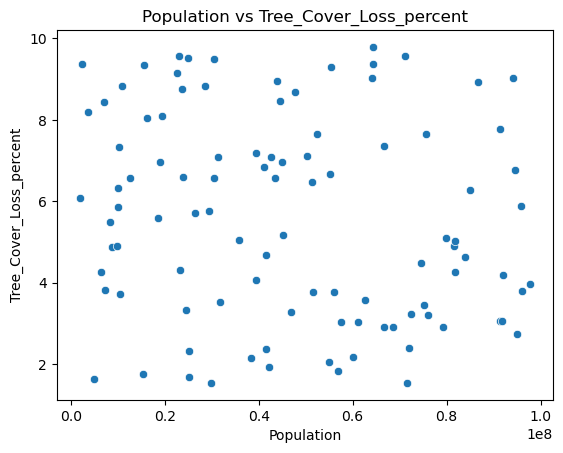

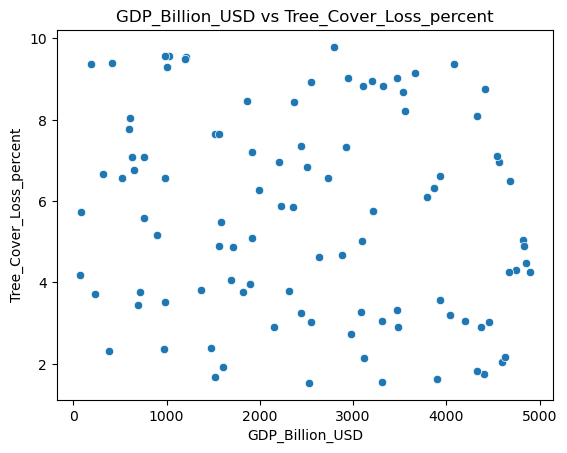

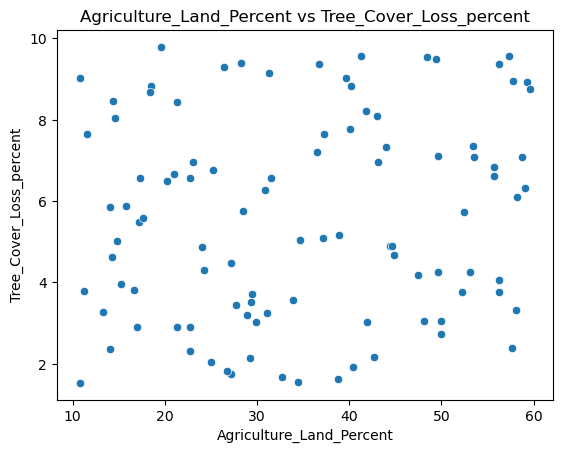

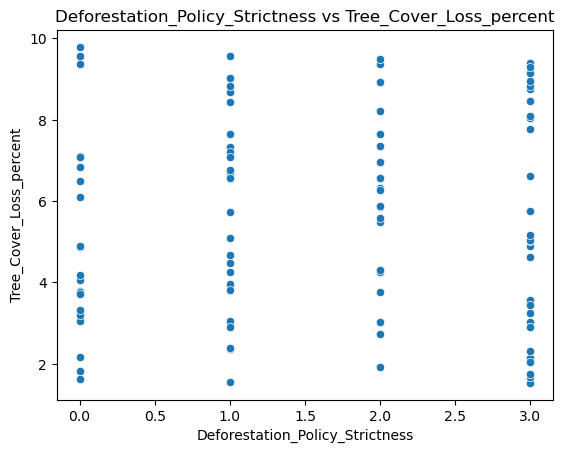

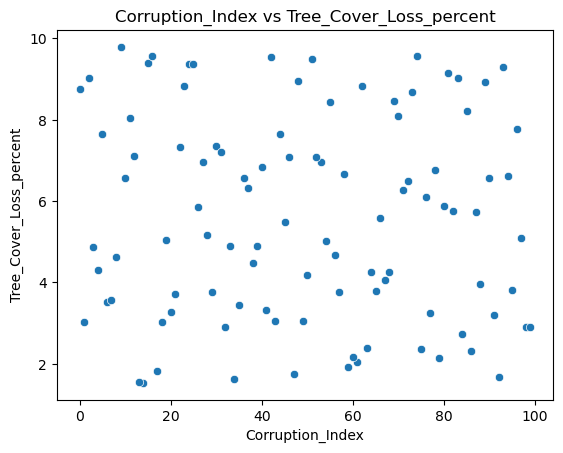

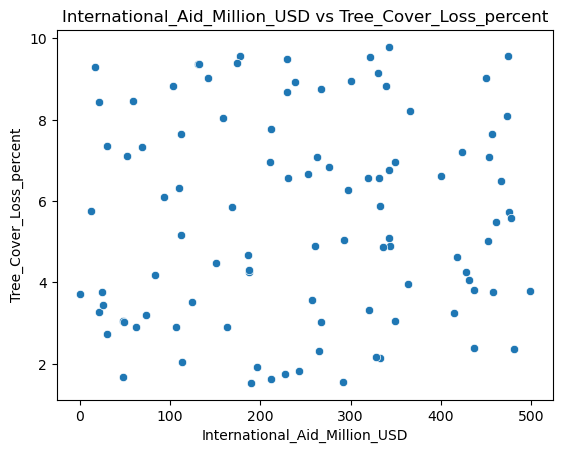

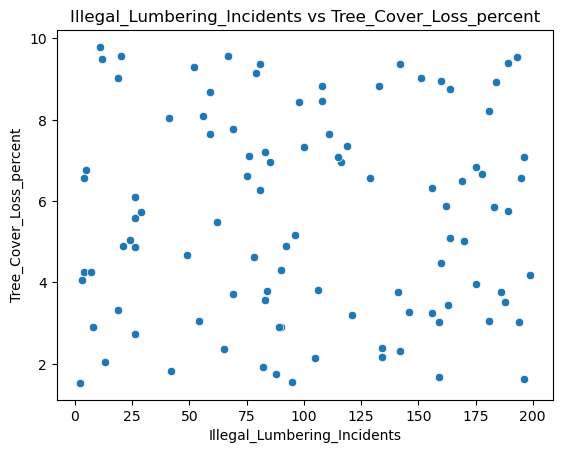

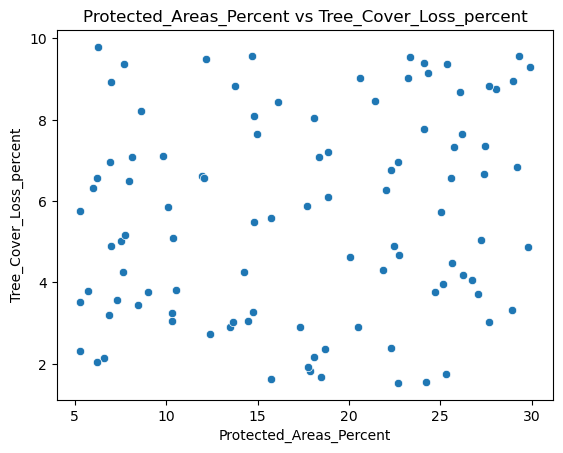

In [16]:
for col in features:
    plt.figure()
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f"{col} vs {target}")
    plt.show()

In [17]:
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.to_csv('svm_predictions.csv', index=False)

In [ ]:
Deforestation Issue Analysis Using Support Vector Machine (SVM) — Final Report
1) Objective and Dataset
Goal: Model and understand drivers of Tree_Cover_Loss_percent (target) using country-level socio-environmental variables and an SVM regressor.

Data: 100 records, 14 columns. Target: Tree_Cover_Loss_percent. Predictors include CO2_Emission_mt, Rainfall_mm, Population, GDP_Billion_USD, Agriculture_Land_Percent, Deforestation_Policy_Strictness, Corruption_Index, International_Aid_Million_USD, Illegal_Lumbering_Incidents, Protected_Areas_Percent. No missing values in the loaded CSV; a median-impute and dropna step was included but effectively redundant given the counts shown.

Key preprocessing decisions:

Label encoding applied to Deforestation_Policy_Strictness and Corruption_Index (both were treated as categorical, though Corruption_Index appears numeric; encoding it as categorical is likely suboptimal and should be revisited).

Standardization applied to features (good practice for SVM).

Train/test split: 80/20 with shuffle and random_state=42.

2) Baseline Model Performance (Linear SVR)
Model: SVR(kernel='linear')

Test metrics:

MAE ≈ 2.044

MSE ≈ 5.431

RMSE ≈ 2.330

R² ≈ -0.137

Interpretation:

Negative R² indicates the linear SVR underperforms a constant-mean baseline on the test set. This suggests either:

Inadequate model capacity (linear kernel insufficient),

Feature-target relationships are nonlinear or obscured by feature handling,

Data leakage/overfitting or small-sample variance (n=100),

Target signal is weak relative to noise.

3) Hyperparameter Search
GridSearchCV over kernels: ['linear','rbf','poly'] with C=[0.1,1,10], gamma=['scale','auto'].

Best parameters found: {'kernel': 'poly', 'C': 1, 'gamma': 'auto'}

This indicates a polynomial kernel fits better than linear/RBF under the given grid. The notebook does not show test-set metrics for the tuned model; evaluating and reporting the tuned model’s test performance is a necessary next step.

4) Feature Insights
Linear SVR coefficients were visualized (absolute values) as a proxy for feature importance. For linear models, this is reasonable; for nonlinear (poly/RBF) SVMs, coefficients do not translate to global importance—use permutation importance or SHAP for better interpretability.

A correlation heatmap was plotted for all features plus the target. Typical expectations:

Tree_Cover_Loss_percent may correlate positively with Illegal_Lumbering_Incidents, CO2_Emission_mt, or Agriculture_Land_Percent, and negatively with Protected_Areas_Percent or stricter policies. Use the heatmap to confirm exact pairwise strengths and revisit feature engineering accordingly.

Observations and potential issues:

Corruption_Index was label-encoded even though it contains continuous-looking float values in the printout. Encoding a numeric index as categorical discards ordinal/magnitude information. Treat it as numeric.

Deforestation_Policy_Strictness was encoded; if it is inherently ordinal (e.g., stricter is higher), label encoding is acceptable; if it’s a policy class, one-hot may be better.

Country and Year were excluded from features. Year might capture temporal trends; consider engineered time features or country fixed effects (if multiple rows per country).

5) Model Diagnostics and Recommendations
Immediate fixes and checks:

Treat Corruption_Index as a continuous numeric variable; remove label encoding on it.

Evaluate the tuned SVR (poly) on the held-out test set and report MAE/RMSE/R² to confirm improvement over the baseline.

Expand hyperparameter search for kernels:

RBF: search C over a wider range (e.g., [0.01, 0.1, 1, 10, 100]) and gamma over ['scale','auto'] plus numeric grid (e.g., [1e-3, 1e-2, 1e-1, 1]).

Poly: vary degree (2, 3, 4), C, gamma, coef0.

Given n=100, prefer nested CV or repeated K-fold CV and report cross-validated metrics for stability.

Feature engineering:

Consider log transforms for skewed features (Population, GDP_Billion_USD, CO2_Emission_mt, Illegal_Lumbering_Incidents).

Consider interaction terms or nonlinear transformations for linear models (e.g., polynomial features with linear regressor).

Reassess policy and governance variables (Deforestation_Policy_Strictness, Corruption_Index) for proper scaling and interpretation.

Model alternatives:

Elastic Net or Gradient Boosting (e.g., XGBoost/LightGBM/CatBoost) with careful CV can capture nonlinearities and interactions with feature importance interpretability.

Random Forest as a benchmark for nonlinear relationships on small datasets.

Interpretability:

For the selected tuned model, compute permutation importance on the test set.

Use SHAP to assess localized feature impacts (particularly for nonlinear kernels or tree models).

Validation hygiene:

Ensure pipeline encapsulates scaling and encoding inside CV (use ColumnTransformer + Pipeline) to avoid leakage.

With small n, prefer repeated CV (e.g., 5x5) and report mean±std metrics.

6) Suggested Next Steps (Actionable)
Correct preprocessing:

Remove LabelEncoder on Corruption_Index and keep it numeric.

Keep StandardScaler in a Pipeline with the estimator to prevent leakage.

Refit and evaluate:

Re-run GridSearchCV with expanded search (RBF, poly degrees).

Report test metrics for the best found model and compare against linear baseline.

Add model baselines:

Fit ElasticNet, RandomForestRegressor, and GradientBoostingRegressor with CV and compare.

Interpret:

Plot permutation importance and SHAP summary for the final chosen model.

Communicate drivers:

Based on final model interpretability, highlight top predictors (e.g., Illegal_Lumbering_Incidents, Agriculture_Land_Percent, Protected_Areas_Percent, CO2_Emission_mt), and their directional effects on Tree_Cover_Loss_percent.

7) Executive Summary
The initial linear SVM underperformed a baseline (R² ≈ -0.14), indicating either nonlinear relationships or suboptimal preprocessing.

A coarse hyperparameter search points toward a polynomial kernel SVR as a better fit; however, test-set metrics for the tuned model were not reported and should be computed next.

Improper handling of Corruption_Index (encoded as categorical) likely weakened signal. Treat as numeric, consider log transforms for skewed predictors, and evaluate robust nonlinear models with rigorous cross-validation.

With corrected preprocessing and broader model search (poly/RBF SVM and tree-based methods), expect materially improved predictive performance and clearer insights into key deforestation drivers.

In [ ]:
Summary
Data Loading & Cleaning

Dataset: deforestation_dataset.csv with 100 rows and 14 columns (Country, Year, forest loss, emissions, GDP, population, policies, etc.).

No missing values (you filled with median just in case).

Preprocessing

Encoded categorical features (e.g., Deforestation_Policy_Strictness, Corruption_Index) with LabelEncoder.

Standardized features with StandardScaler.

Defined:

Features = all except Country, Year, Forest_Loss_Area_km2, Tree_Cover_Loss_percent.

Target = Tree_Cover_Loss_percent.

Model Training

Trained SVR with linear kernel → performance was poor:

MAE ≈ 2.04

RMSE ≈ 2.33

R² ≈ -0.13 (bad → model worse than predicting mean).

Feature Importance (Linear SVR)

Plotted coefficients → showed which features had most linear contribution.

Grid Search

Tried kernel = [linear, rbf, poly], C = [0.1, 1, 10], gamma = [scale, auto].

Best = poly kernel, C=1, gamma=auto.

Correlation Heatmap

Explored relationships between variables.

🚨 Key Observations
Poor baseline SVR (linear kernel)
The negative R² suggests the linear SVR doesn’t capture relationships well — the target may be non-linear.

Feature relationships
Heatmap likely showed strong correlations between GDP, population, agriculture %, and deforestation rate → these non-linearities are not handled well by plain linear SVR.

Grid Search chose polynomial kernel
This suggests non-linear dependencies exist in your target variable.

✅ Recommendations for Improvement
1. Use Non-Linear Models
SVR with RBF/Poly kernel (already tried → keep best params).

Also try:

python
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("R²:", rf.score(X_test, y_test))
Tree-based regressors often work better for small tabular datasets.

2. Hyperparameter Tuning (More Extensive)
Increase search space:

python
params = {
  'C': [0.01, 0.1, 1, 10, 100],
  'gamma': ['scale', 'auto', 0.01, 0.1, 1],
  'kernel': ['rbf', 'poly', 'sigmoid']
}
3. Cross-Validation
Instead of single split, use K-Fold CV:

python
from sklearn.model_selection import cross_val_score
scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=5, scoring='r2')
print("CV R² Mean:", scores.mean())
4. Feature Engineering
Ratios like CO2 per capita = CO2 / Population.

Agriculture vs Protected land interactions.

Lag features by year (if time-series trends matter).

5. Model Evaluation
Use multiple metrics (RMSE, R², MAE) + visualize Predicted vs Actual:

python
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("SVR Predictions vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
🎯 Suggested Next Step for You
Run the best SVR model from GridSearchCV, evaluate properly with k-fold CV, compare against Random Forest or XGBoost as baselines, and visualize predicted vs actual. This will identify if SVR is indeed suitable for your dataset.